**Part 2 - Model in 2D for f_WB using the IEM closure**

This notebook implements the interaction by exchange with the mean model (IEM) as introduced by (Dopazo, C. & O'Brien, E. 1974) and discussed by (Pope, S.B. 2010), in order to obtain a closure for the buoyancy equation

\begin{align}
    \frac{D \boldsymbol{U} }{Dt} &= -\nabla P + B \boldsymbol{\hat{z}} + Re^{-1} \Delta \boldsymbol{U}, \quad \nabla \cdot \boldsymbol{U} = 0, \\
    \frac{D B }{Dt}      &= Pe^{-1}  \Delta B.
\end{align}

We model the time evolution of the PDF $f_{\boldsymbol{Y}}$ for $\boldsymbol{Y} = (W,B)$.


*Evolution equation*

The joint pdf $f_{\boldsymbol{Y}}$ evolves according to 

\begin{equation}
    \frac{\partial f_{\boldsymbol{Y}} }{\partial t} = - \frac{\partial }{\partial b} \left( \left[ \boldsymbol{D}^{(1)} + \alpha  \Delta B \right] f_{\boldsymbol{Y}} \right) - \frac{\partial }{\partial w} \left( \mathbb{E}_{\boldsymbol{Y}}[ - \nabla_Z P + B + \nu  \Delta W ] f_{\boldsymbol{Y}} \right)
\end{equation}

The term $\boldsymbol{D}^{(1)}$ is responsible for forcing from internal heating or sources/sinks of buoyancy at the boundaries. Terms $\mathbb{E}_{\boldsymbol{Y}}[\alpha  \Delta B ]$ and $\mathbb{E}_{\boldsymbol{Y}}[ \nu  \Delta W ]$ are responsible for micro-scale molecular mixing locally in buoyancy space and in for viscous dissipation in velocity space. Both terms are unknown and must be modelled. The last term corresponds to the imbalance of the vertical pressure gradient and buoyancy conditioned on $\boldsymbol{Y}$. 

*Molecular mixing closure*

For the conditional diffusion term we will employ the IEM model. 
\begin{equation}
  \mathbb{E}_{\boldsymbol{Y}}[ \alpha \Delta B ] = -\frac{\alpha}{\tau_{B}(t)} \left( b - \mathbb{E}_W[B] \right),
\end{equation}

where $\tau_B(t)$ defines a characteristic time-scale of the buoyancy fluctuations.

*Velocity PDF closure*

For the conditional diffusion term we will employ the IEM model. 
\begin{equation}
  \mathbb{E}_{\boldsymbol{Y}}[ \alpha \Delta W ] f_{\boldsymbol{Y}} = -\frac{\nu}{\tau_{W}(t)} \left( w - \mathbb{E}[W] \right) f_{\boldsymbol{Y}} + (C_0 \epsilon)^{1/2} d \mathcal{W},
\end{equation}

where $\tau_W(t)$ defines a characteristic time-scale of the velocity fluctuations and $\mathcal{W}_t$ a Wiener process.

*Pressure Gradient*

To model the vertical pressure gradient we can volume integrating the Boussinesq equations to obtain
\begin{equation}
\frac{1}{V} \int_{\Omega} \frac{\partial W}{\partial t} d \mathbb{x} = \frac{1}{V} \int_{\Omega} \left( -\nabla_Z P + B \right) d \mathbb{x}
\end{equation}
provided we have periodic boundary conditions or $W=0$ on the domain boundary $\partial \Omega$. This implies that the time-rate of change of the vertical velocity is zero if the system is in hydrostatic balance $\mathbb{E}[-\nabla_Z P + B] = 0$. This suggests at least to first order hydrostatic equilibrium may provide a good approximation. A variety of 2D simulations also support this conclusion. Expanding this relation we obtain

\begin{align*}
\mathbb{E}[-\nabla_Z P + B] &= 0,\\
\mathbb{E}_Y[-\nabla_Z P] &= -\mathbb{E}_W[B],\\
\mathbb{E}_Y[B-\nabla_Z P] &= \mathbb{E}_Y[B] - \mathbb{E}_W[B],\\
\mathbb{E}_W[ \mathbb{E}_Y[B] ] - \mathbb{E}_W[B] &= 0, \\
\end{align*}
and so we use the average of $B$ conditioned on $W$ ($\mathbb{E}_Y[-\nabla_Z P] = -\mathbb{E}_W[B]$) to model the conditional average of the vertical pressure gradient.

*Closed evolution equation*

Substituting the closures for the unknown terms we obtain a system of two coupled SDEs

\begin{align}
dB_t &= \boldsymbol{D}^{(1)}(W_t,B_t,t) dt - \omega_B \left( B_t - \mathbb{E}_{W_t}[B_t] \right) dt + \sigma_B d\mathcal{W}_t, \\
dW_t &= (B_t -\mathbb{E}_W[B_t]) dt - \omega_W \left( W_t - \mathbb{E}_{B_t}[W_t] \right) dt + \sigma_W d\mathcal{W}_t.
\end{align}

which is an McKean-Vlasov equation, as

\begin{equation}
\mathbb{E}_W[B] = \int b f_{B|W}(b|w;t) db = \int b \frac{f_{WB}(w,b;t)}{f_W(w;t)} db,
\end{equation}

depends on the global PDF at each time-instant. Subject to specifying $\tau_B$ and $\tau_W$ and suitable boundary conditions this equation is closed and can be solved numerically.  Below we implement this equation using a Monte-Carlo method specifying $\tau_B = \tau_W = 1$.

**Setup**

We first import the required libraries to implement this model.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as trapz
from derivatives import *
from scipy.stats import gaussian_kde, norm


We then define a computation grid for $f_{BW}(b,w;t)$ in terms of $b,w$. 

In [11]:
# Boundary conditions
bc_b = 'Neumann'
bc_w = 'Neumann'

# Numerical resolution
N_b = 64
N_w = 64 + 1

# Domain
b_min =-5
b_max = 5
w_min =-10
w_max = 10
b_grid = np.linspace(b_min, b_max, N_b)
w_grid = np.linspace(w_min, w_max, N_w) 

# Time-scales
omega_B = .75
omega_W = .75

sigma_B = .2             # Diffusion coefficient
sigma_W = .2             # Diffusion coefficient

Then we set up the system of SDEs

In [12]:
def Apply_BC(x, x_max, x_min):
    """
    Enforce the reflecting boundary conditions equivalent to Neumann.
    """

    # Reflect back inside the top/right hand boundary
    x = np.where(x > x_max, x_max - (x - x_max), x) 
    
    # Reflect back inside the bottom/left hand boundary
    x = np.where(x < x_min, x_min + (x_min - x), x) 

    return x


def density(X,Y, N_X=64, N_Y=64):

    f_XY, x_edges, y_edges = np.histogram2d(X, Y, bins=(N_X,N_Y), density=True)
    x = .5*(x_edges[1:] + x_edges[:-1])
    y = .5*(y_edges[1:] + y_edges[:-1])

    dx = x[1]-x[0]
    dy = y[1]-y[0]

    I_x = np.ones(N_X)
    I_y = np.ones(N_Y)

    f_X = np.sum(f_XY, axis=0)*dx
    f_Y = np.sum(f_XY, axis=1)*dy

    # EY_X
    #EX_cY = np.sum(np.outer(x,I_y)*f_XY,axis=0)*dx/f_Y

    # EX_Y
    #EY_cX = np.sum(np.outer(I_x,y)*f_XY,axis=1)*dx/f_X

    return f_XY, f_X, f_Y, x,y 


def density_kde(X,Y):
    """Calculates the expectation of X given Y"""

    # Step 1: Estimate the joint density f_{X,Y}(x, y)
    data = np.vstack([X, Y])  # Stack X and Y into a 2D array
    kde_joint = gaussian_kde(data)

    # Step 2: Estimate the marginal density f_Y(y)
    kde_y = gaussian_kde(Y)

    # Step 3: Compute the conditional density f_{X|Y}(x|y)
    def conditional_density(x, y):
        return kde_joint([x, y]) / kde_y(y)
    
    # Step 4: Calculate the conditional expectation E[X|Y=y]
    def conditional_expectation(y):
        # Numerical integration to find E[X | Y=y]
        x_values = np.linspace(min(X), max(X), 1000)
        cond_density_values = np.array([conditional_density(x, y) for x in x_values])
        return np.sum(x_values * cond_density_values) * (x_values[1] - x_values[0])

    return conditional_expectation

def plotter(f_XY, f_X, f_Y, x,y):
    
    fig, ax = plt.subplots(nrows=2, ncols=2, layout='constrained')

    # First column
    ax[0,0].set_ylabel('$f_b$')
    ax[0,0].set_xlabel('$b$')
    ax[0,0].plot(x, f_X)

    ax[1,0].set_title(r'$f$')
    cf = ax[1,0].pcolormesh(x,y,f_XY.T, cmap='Reds')#, norm='log')
    #fig.colorbar(cf, ax=ax1)
    ax[1,0].set_xlabel('$b$')
    ax[1,0].set_ylabel('$w$')

    # First column
    fig.delaxes(ax[0,1])

    ax[1,1].set_ylabel('$w$')
    ax[1,1].set_xlabel('$f_w$')
    ax[1,1].plot(f_Y, y)

    plt.show()

    return None


def solver(T, dt, num_particles = 10**3):
    
    # Parameters
    #num_particles = 10**3  # Number of Monte Carlo samples
    num_steps = int(T//dt)      # Time steps
    #dt = 0.1               # Time step size

    # Brownian increments
    dW_t = np.sqrt(dt) * norm.rvs(loc=0, scale=1, size=(num_particles, num_steps, 2))  

    # Container
    b = np.zeros((num_particles, num_steps))
    w = np.zeros((num_particles, num_steps))

    # Initial conditions, half of the particles to +1 and the other to -1
    b0 = norm.rvs(loc=0, scale=1, size=num_particles)
    w0 = norm.rvs(loc=0, scale=1, size=num_particles)

    b[:,0] = b0             
    w[:,0] = w0
    
    # Euler Maruyama
    for n in range(1, num_steps):

        # Conditional means
        f_XY, f_X, f_Y, x,y, EY_cX, EX_cY = density(X=b[:, n-1], Y=w[:, n-1]) 

        #if n%(num_steps//10) == 0:
        plotter(f_XY, f_X, f_Y, x,y)

        EW_cB = np.interp(x=b[:, n-1], xp=x, fp=EY_cX)
        EB_cW = np.interp(x=w[:, n-1], xp=y, fp=EX_cY)

        # Update particles
        b[:, n] = b[:, n-1]                            - omega_B*(b[:, n-1] - EB_cW) * dt   + sigma_B * dW_t[:,n-1,0]
        w[:, n] = w[:, n-1] + (b[:, n-1] - EB_cW) * dt - omega_W*(w[:, n-1] - EW_cB) * dt   + sigma_W * dW_t[:,n-1,1]

        # Apply Reflecting/bcs
        b[:, n] = Apply_BC(b[:, n], b_max, b_min)
        w[:, n] = Apply_BC(w[:, n], w_max, w_min)
    
    return b, w

This system is then solved

/tmp/ipykernel_20440/3827185607.py:31: RuntimeWarning: divide by zero encountered in divide
  EX_cY = np.sum(np.outer(x,I_y)*f_XY,axis=0)*dx/f_Y
/tmp/ipykernel_20440/3827185607.py:31: RuntimeWarning: invalid value encountered in divide
  EX_cY = np.sum(np.outer(x,I_y)*f_XY,axis=0)*dx/f_Y
/tmp/ipykernel_20440/3827185607.py:34: RuntimeWarning: divide by zero encountered in divide
  EY_cX = np.sum(np.outer(I_x,y)*f_XY,axis=1)*dx/f_X
/tmp/ipykernel_20440/3827185607.py:34: RuntimeWarning: invalid value encountered in divide
  EY_cX = np.sum(np.outer(I_x,y)*f_XY,axis=1)*dx/f_X


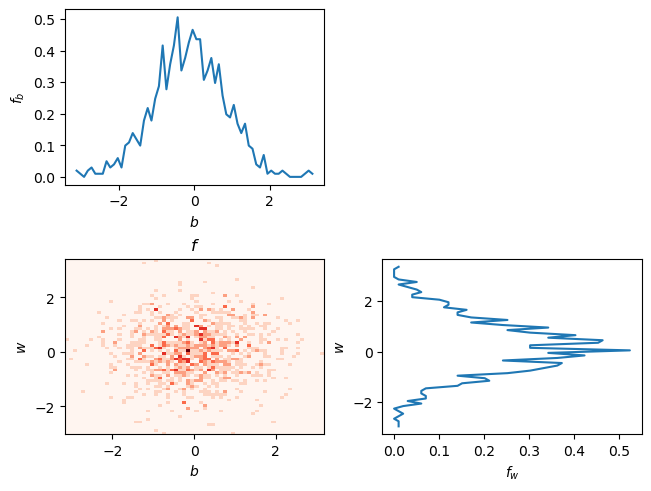

ValueError: autodetected range of [nan, nan] is not finite

In [13]:
solver(T=.05,dt=0.01)